<a href="https://colab.research.google.com/github/nehapokharel/AI-workshop-assignment/blob/master/soil_feature_predition_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [2]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from numpy import asarray
from PIL import Image
import pandas as pd
import numpy as np
import os 

# **Making content of google drive accessible**

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Location of our data folder**

In [4]:
!ls "/content/gdrive/My Drive/Agriculture_Dataset"

clay  clayley_loam  loam  loamy_clay  loamy_sand  sandy  sandy_loam


# New section

In [5]:
type_classes = ["clay", "loam", "loamy_sand", "sandy_loam", "clayley_loam", "loamy_clay", "sandy", "sandy_loam"]
n_type = len(type_classes)

In [6]:
color_classes = ["brown", "black", "yellow", "red", "grey"]
n_color = len(color_classes)

In [7]:
compactness_classes = ["compact", "loose"]
n_compactness = len(compactness_classes)

# **Function to load dataset from Google Drive and append the images into the list x and labels in list y.**

In [8]:
def load_soil_images():
    x=[]
    y=[]
    soil_type = []
    soil_color = []
    soil_compactness = []
    channel = 3
    data_dir = "/content/gdrive/My Drive/Agriculture_Dataset"
    for soil, t in enumerate(type_classes):
        for color, c in enumerate(color_classes):
           for compact, o in enumerate(compactness_classes):
             image_path = data_dir + '/' + t + '/' + c + '/'+ o
             for file in os.listdir(image_path):
               if file.endswith(".jpeg") or file.endswith(".jpg"):
                 img = Image.open(os.path.join(data_dir, t, c, o, file)) 
                 width, height = img.size
                 newsize = (256, 256)
                 img = img.resize(newsize) 
                 pixels = asarray(img)
                 pixels = pixels.astype('float32')
                 pixels /= 255.0
                 if pixels.shape==(256,256,3):
                     x.append(pixels)
                     z = ['soil_' + t,'color_' + c, 'comp_' + o]
                     y.append(z)
    return x, y  

In [9]:
x, y = load_soil_images()

In [10]:
 #printing length of x and y

 print("Length of x",len(x))
 print("Length of y",len(y))

Length of x 334
Length of y 334


# **Splitting the dataset into train and test dataset**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

# **Converting lists to numpy array**

In [12]:
X_train=np.array(X_train)
type(X_train)

numpy.ndarray

In [13]:
X_test=np.array(X_test)
type(X_test)

numpy.ndarray

In [14]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
y_train.shape

(267, 3)

In [16]:
y_test.shape

(67, 3)

**Implementing [MultiBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) library from sklearn**


In [17]:
mlb = MultiLabelBinarizer()
y_train= mlb.fit_transform(y_train)
y_train.shape

(267, 14)

In [18]:
y_test= mlb.fit_transform(y_test)
y_test.shape

(67, 14)

In [19]:
mlb.classes_

array(['color_black', 'color_brown', 'color_grey', 'color_red',
       'color_yellow', 'comp_compact', 'comp_loose', 'soil_clay',
       'soil_clayley_loam', 'soil_loam', 'soil_loamy_clay',
       'soil_loamy_sand', 'soil_sandy', 'soil_sandy_loam'], dtype=object)

In [20]:
n_classes=len(mlb.classes_)
n_classes

14

## **Visualization**

In [21]:
def visualize_images(x, y, n_images= 16, n_cols=4):
    label_by_index= mlb.inverse_transform(y)
    n_rows = n_images // n_cols
    random_indexes = np.random.choice(len(x), size=n_images, replace=True)
    labels = np.argmax(y[random_indexes], axis=1)
    plt.figure(figsize=(n_rows * 4, n_cols * 4))
    for i, k in enumerate(random_indexes):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.subplots_adjust(hspace=0.4)
        plt.imshow(x[k])
        plt.title(label_by_index[k])  
    plt.tight_layout()       
    plt.show()


Train images:


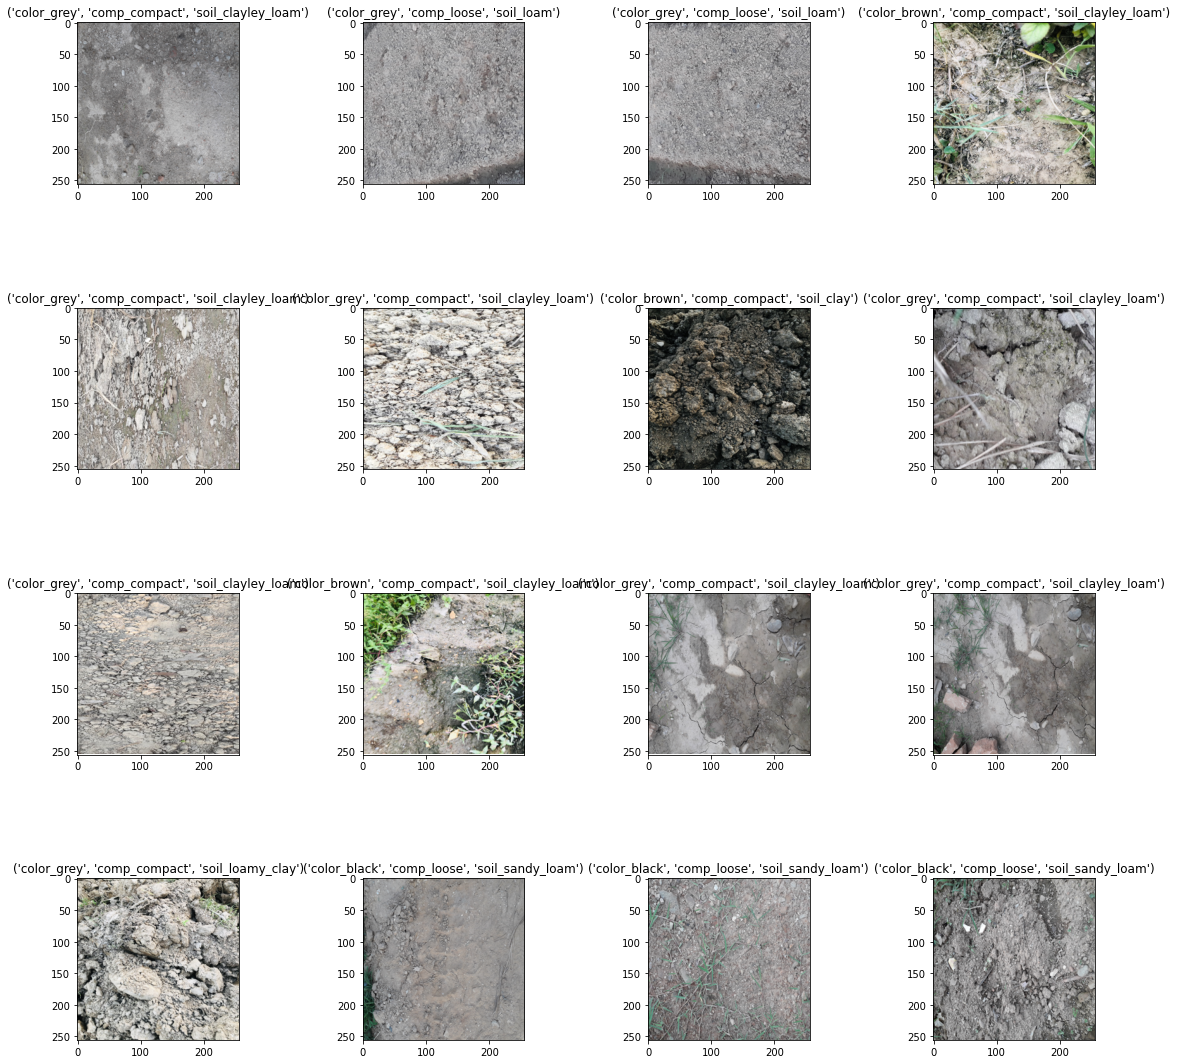

Validation images:


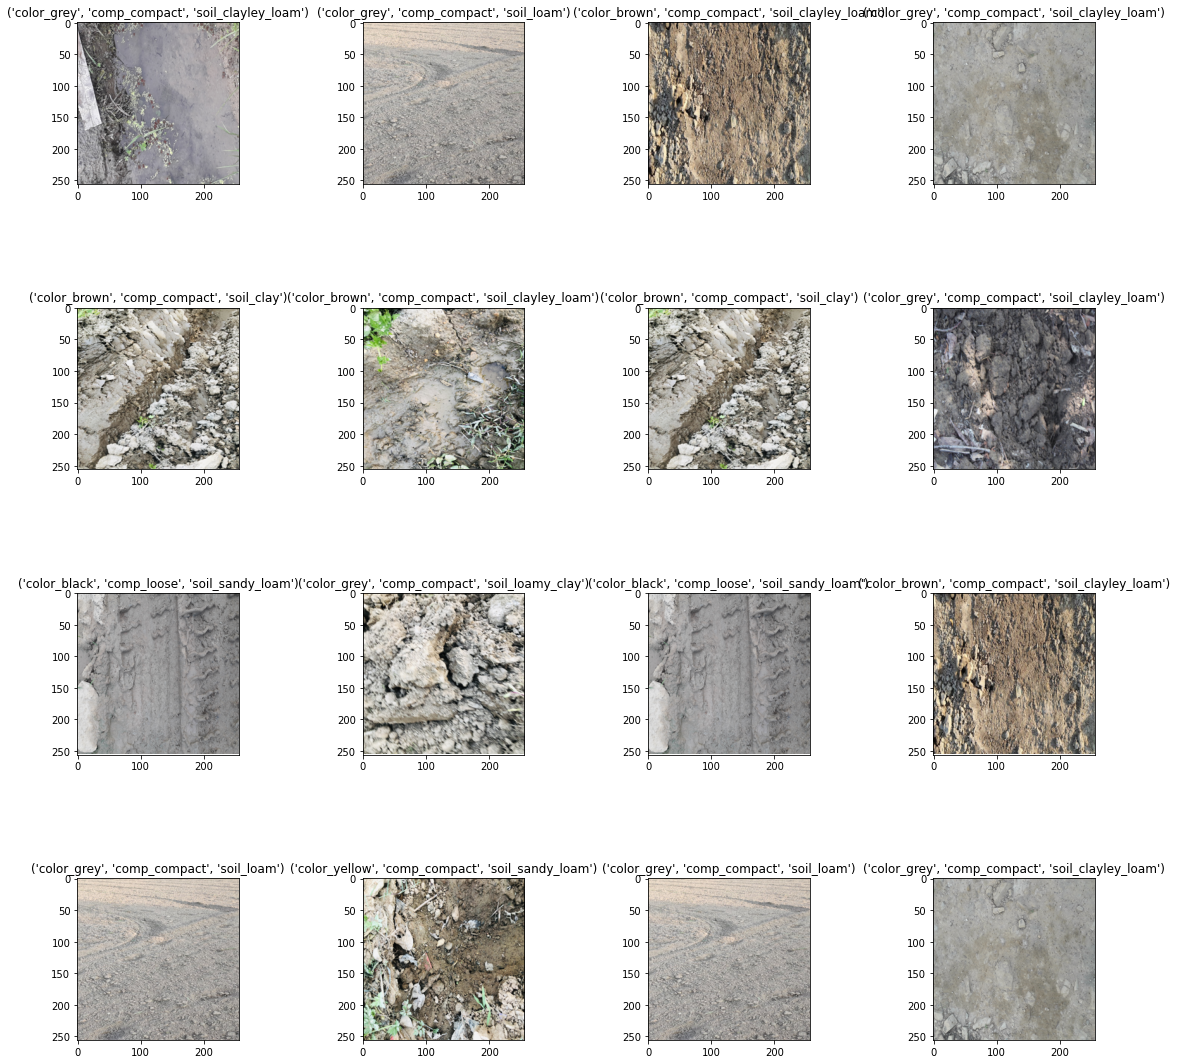

In [22]:
print("Train images:")
visualize_images(X_train, y_train)
print("Validation images:")
visualize_images(X_test, y_test)

## **Model**



* padding=same

"same" results in padding with zeros evenly to the left/right or up/down of the 
input such that output has the same height/width dimension as the input.

*   List item


In [23]:
def image_classifier_model():
    model = Sequential(name="SoilFeature")
    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=X_train.shape[1:]))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (4, 4), padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(64, (4, 4), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (4, 4), padding="same"))
    model.add(Activation("relu"))
    
    model.add(Conv2D(128, (4, 4), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation="sigmoid"))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
    
    return model

In [24]:
model = image_classifier_model()

In [25]:
model.summary()

Model: "SoilFeature"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        

# **Model Fitting**

In [26]:
history  = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test), shuffle=True)
print(history)

Epoch 1/20
5/5 [==============================] - 51s 419ms/step - loss: 1.1903 - accuracy: 0.1487 - val_loss: 1.5007 - val_accuracy: 0.3433
Epoch 2/20
5/5 [==============================] - 1s 113ms/step - loss: 1.1107 - accuracy: 0.2308 - val_loss: 2.7660 - val_accuracy: 0.4478
Epoch 3/20
5/5 [==============================] - 1s 110ms/step - loss: 0.8670 - accuracy: 0.2281 - val_loss: 1.6258 - val_accuracy: 0.4627
Epoch 4/20
5/5 [==============================] - 1s 115ms/step - loss: 0.8162 - accuracy: 0.2283 - val_loss: 2.1583 - val_accuracy: 0.4478
Epoch 5/20
5/5 [==============================] - 1s 114ms/step - loss: 0.7796 - accuracy: 0.1391 - val_loss: 1.5020 - val_accuracy: 0.0746
Epoch 6/20
5/5 [==============================] - 1s 113ms/step - loss: 0.7268 - accuracy: 0.2104 - val_loss: 2.2405 - val_accuracy: 0.4776
Epoch 7/20
5/5 [==============================] - 1s 110ms/step - loss: 0.7144 - accuracy: 0.2647 - val_loss: 3.1077 - val_accuracy: 0.4627
Epoch 8/20
5/5 [===

**Accuracy graph**

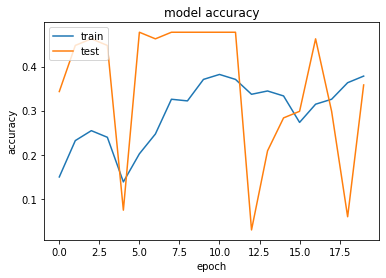

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Loss graph**

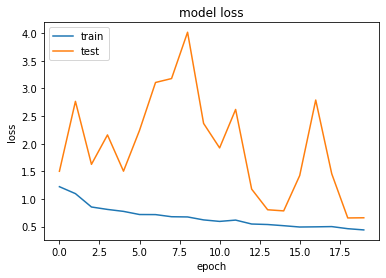

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Predictions**

In [29]:
from google.colab import files
uploaded = files.upload()

Saving 20210421_165210.jpg to 20210421_165210.jpg


In [30]:
image_filename = list(uploaded.keys())[0]

In [31]:
from io import BytesIO
im = Image.open(BytesIO(uploaded[image_filename]))

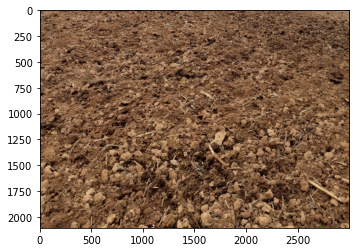

In [32]:
plt.imshow(im)
plt.show()

In [33]:
im.size

(3000, 2107)

In [34]:
t=[]
width, height = im.size
newsize = (256, 256)
img1 = im.resize(newsize) 
pixels = asarray(img1)
pixels = pixels.astype('float32')
pixels /= 255.0
if pixels.shape==(256,256,3):
    t.append(pixels)

In [35]:
t[0] = np.expand_dims(t[0], axis = 0)

In [36]:
t[0].shape

(1, 256, 256, 3)

In [37]:
probas=model.predict(t[0])
probas

array([[3.4421550e-03, 3.1712389e-01, 1.3707731e-03, 9.9999964e-01,
        1.4150133e-03, 9.9923086e-01, 5.2897126e-04, 9.8943782e-01,
        1.2386182e-01, 1.2935767e-01, 2.2693399e-02, 9.2347488e-02,
        1.2539936e-03, 7.9839968e-04]], dtype=float32)

In [38]:
a = probas.tolist()
flat_list = [item for sublist in a for item in sublist]
flat_list

[0.0034421549644321203,
 0.3171238899230957,
 0.0013707730686292052,
 0.9999996423721313,
 0.0014150133356451988,
 0.9992308616638184,
 0.0005289712571538985,
 0.9894378185272217,
 0.12386181950569153,
 0.12935766577720642,
 0.022693399339914322,
 0.09234748780727386,
 0.0012539935996755958,
 0.0007983996765688062]

In [39]:
mlb.classes_

array(['color_black', 'color_brown', 'color_grey', 'color_red',
       'color_yellow', 'comp_compact', 'comp_loose', 'soil_clay',
       'soil_clayley_loam', 'soil_loam', 'soil_loamy_clay',
       'soil_loamy_sand', 'soil_sandy', 'soil_sandy_loam'], dtype=object)

In [40]:
label_index_list = []
soil_color_index = []
color = {}
soil_compactness_index = []
compactness_dict = {}
compactness = {}
soil_type_index = []
type_dict = {}
stype = {}
for index in range(len(flat_list)):
  if index>=0 and index<5:
    color_dict = {index:flat_list[index]}
  color.update(color_dict)
  if index>4 and index<7:
    compactness_dict = {index:flat_list[index]}
  compactness.update(compactness_dict)
  if index>6 and index<12:
    type_dict = {index:flat_list[index]}
  stype.update(type_dict)


soil_color_index.append(color.copy())
soil_compactness_index.append(compactness.copy())
soil_type_index.append(stype.copy())

label_index_list.append(soil_color_index)
label_index_list.append(soil_compactness_index)
label_index_list.append(soil_type_index)

print(label_index_list)

[[{0: 0.0034421549644321203, 1: 0.3171238899230957, 2: 0.0013707730686292052, 3: 0.9999996423721313, 4: 0.0014150133356451988}], [{5: 0.9992308616638184, 6: 0.0005289712571538985}], [{7: 0.9894378185272217, 8: 0.12386181950569153, 9: 0.12935766577720642, 10: 0.022693399339914322, 11: 0.09234748780727386}]]


In [41]:
len(label_index_list)

3

In [42]:
final_labels =[]

for l in range(len(label_index_list)):
  for i in label_index_list[l]:
    final_labels.append(max(i, key=i.get))
print(final_labels)

[3, 5, 7]


In [43]:
for i in final_labels:
    print(mlb.classes_[i])

color_red
comp_compact
soil_clay
